# Fuel Station Example

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](
    https://colab.research.google.com/github/vitostamatti/discrete-event-simulation-simpy/blob/main/notebooks/04-fuel_station_example.ipynb
    )


![image](../figures/fuel_station.png)

In [583]:
# Fuel Station Example

import simpy
from typing import List
import numpy as np
import datetime
import pandas as pd
import matplotlib.pyplot as plt
import random




class Vehicle():
    def __init__(
            self, 
            id, 
            charge, 
            capacity
            ):

        self.id = id
        self.charge = charge 
        self.capacity = capacity


class Employee():
    def __init__(self, env, id):
        self.env = env
        self.id = id
        self.idle = True



class Pump():
    def __init__(self, env:simpy.Environment, id, pump_speed=0.11):
        self.env = env
        self.id = id
        self.pump_speed = pump_speed

        self.entry_queu = []
        self.process_queu = []
        self.exit_queu = []
        self.employee = None
        self.idle = True
        self.total_served = 0


    def vehicle_entered(self, vehicle:Vehicle):
        print(f"{self.env.current_date} - Vehicle {vehicle.id} entered Pump {self.id}")

        self.env.record_metric(name='queu_time', value={
            "pump":f"{type(self).__name__}-{self.id}",
            "vehicle":f"{type(vehicle).__name__}-{vehicle.id}",
            "action":"entered",
            "time":self.env.current_date
            })

        # Register queu lenght
        self.env.record_metric(name='queus', value={
            "pump":f"{type(self).__name__}-{self.id}",
            "entry_queu":len(self.entry_queu),
            "time":self.env.current_date
            })

        yield self.env.timeout(0.1)
        self.entry_queu.append(vehicle)



    def assign_employee(self, employee):
        print(f"{self.env.current_date} - Employee {employee.id} assigned to Pump {self.id}")

        self.env.record_metric(
            name='siezed_time', 
            value={
                "employee":f"{type(employee).__name__}-{employee.id}",
                "pump":f"{type(self).__name__}-{self.id}",
                "action":"sieze",
                "time":self.env.current_date
            }
        )

        yield self.env.timeout(0.1)
        self.employee = employee
        

    def prepare_charge_vehicle(self, vehicle:Vehicle, employee:Employee):
        print(f"{self.env.current_date} - Vehicle {vehicle.id} preparing in Pump {self.id} by Employee {employee.id}")

        time = np.random.triangular(2*60,3*60,6*60)
        yield self.env.timeout(time)
        self.env.record_metric(name='process_time', value={
            "node":f"{type(self).__name__}-{self.id}",
            "process_name":"prepare_charge",
            "process_time":time,
            "time":self.env.current_date
            })

        self.employee = None
        employee.idle = True

        self.env.record_metric(name='siezed_time', value={
            "employee":f"{type(employee).__name__}-{employee.id}",
            "pump":f"{type(self).__name__}-{self.id}",
            "action":"release",
            "time":self.env.current_date
            })

        self.entry_queu.remove(vehicle)
        self.process_queu.append(vehicle)



    def charge_vehicle(self, vehicle):
        print(f"{self.env.current_date} - Vehicle {vehicle.id} charging in Pump {self.id}")
        self.idle = False
        quantity = vehicle.capacity*vehicle.charge
        time = quantity/self.pump_speed
        yield self.env.timeout(time) 
        self.env.record_metric(name='process_time', value={
            "node":f"{type(self).__name__}-{self.id}",
            "process_name":"charge",
            "process_time":time,
            "time":self.env.current_date
            })

        self.process_queu.remove(vehicle)
        self.exit_queu.append(vehicle)
        self.idle = True



    def prepare_exit_vehicle(self, vehicle:Vehicle, employee:Employee):
        print(f"{self.env.current_date} - Vehicle {vehicle.id} pre-exiting Pump {self.id} by Employee {employee.id}")
        time = np.random.triangular(2*60,5*60,6*60)
        yield self.env.timeout(time)

        self.env.record_metric(name='process_time', value={
            "node":f"{type(self).__name__}-{self.id}",
            "process_name":"prepare_exit_charge",
            "process_time":time,
            "time":self.env.current_date
            })

        self.employee = None
        employee.idle = True

        self.env.record_metric(name='siezed_time', value={
            "employee":f"{type(employee).__name__}-{employee.id}",
            "pump":f"{type(self).__name__}-{self.id}",
            "action":"release",
            "time":self.env.current_date
            })

        self.exit_queu.remove(vehicle)
    

    def vehicle_exited(self, vehicle):
        print(f"{self.env.current_date} - Vehicle {vehicle.id} exited Pump {self.id}")
        self.total_served += 1
        yield self.env.timeout(1)


    def __call__(self):
        while True:            
            if self.employee is not None:
                if len(self.exit_queu)>0:
                    vehicle = self.exit_queu[0]
                    employee = self.employee
                    yield self.env.process(self.prepare_exit_vehicle(vehicle, employee))
                    yield self.env.process(self.vehicle_exited(vehicle))
                else:
                    vehicle = self.entry_queu[0]

                    self.env.record_metric(name='queu_time', value={
                        "pump":f"{type(self).__name__}-{self.id}",
                        "vehicle":f"{type(vehicle).__name__}-{vehicle.id}",
                        "action":"exited",
                        "time":self.env.current_date
                        })

                    employee = self.employee
                    yield self.env.process(self.prepare_charge_vehicle(vehicle, employee))
                    yield self.env.process(self.charge_vehicle(vehicle))
            else:
                yield self.env.timeout(1) 
                


    
class FuelStation():
    
    def __init__(
            self, 
            env:simpy.Environment, 
            pumps:List[Pump], 
            employees:List[Employee], 
            vehicles:List[Vehicle]=[]
        ):
        
        self.env = env
        self.pumps = pumps
        self.employees = employees
        self.vehicles = vehicles
        self.total_arrives = len(vehicles)
        

    def assign_employees(self):
        while True:
            random.shuffle(self.employees)
            for e in self.employees:
                if e.idle:
                    sorted_pumps = sorted(
                        self.pumps, 
                        key=lambda p: len(p.entry_queu)+len(p.process_queu)+len(p.exit_queu),
                        reverse=True
                    ) 
                    for p in sorted_pumps:
                        if p.idle and (len(p.entry_queu)+len(p.exit_queu))>0 and (p.employee==None):
                            e.idle = False
                            self.env.process(p.assign_employee(e))
                            yield self.env.timeout(0.1)
                        else:
                            yield self.env.timeout(0.1)
                else:
                    yield self.env.timeout(0.1)



    def assign_vehicles(self):
        while True:
            if len(self.vehicles)>0:
                random.shuffle(self.pumps)
                sorted_pumps = sorted(
                    self.pumps, 
                    key=lambda p: len(p.entry_queu)+len(p.process_queu)+len(p.exit_queu),
                    reverse=False
                )

                pump = sorted_pumps[0]
                vehicle = self.vehicles.pop(0)
                print(f"{self.env.current_date} - Vehicle {vehicle.id} assigned to Pump {pump.id} total queu {len(pump.entry_queu)+len(pump.process_queu)}")
                yield env.process(pump.vehicle_entered(vehicle))
                yield self.env.timeout(1)
            else:
                yield self.env.timeout(1) 

    def vehicle_arrival(self, interarrival_time=7*60):
        while True:
            yield self.env.timeout(np.random.poisson(lam=interarrival_time))
            vehicle_id = self.total_arrives

            charge = np.random.triangular(
                left=.0, 
                mode=.2, 
                right=.8
                ) 

            capacity = np.random.choice(
                a=[45,65], 
                p=[0.8,0.2]
                )
            
            vehicle = Vehicle(id=vehicle_id, charge=charge, capacity=capacity)
            self.vehicles.append(vehicle)
            print(f"{self.env.current_date} - New Vehicle {vehicle.id} arrived")
            self.total_arrives += 1

    def __call__(self, interarrival_time=7*60):
        for p in self.pumps:
            self.env.process(p())
        self.env.process(self.vehicle_arrival(interarrival_time))
        self.env.process(self.assign_vehicles())
        self.env.process(self.assign_employees())



class SimEnv(simpy.Environment):

    def __init__(self, start_date=None):
        super().__init__()

        self.start_date = (
            start_date if start_date 
            else datetime.datetime.now()
            ) 

        self.metrics = {}

    @property
    def current_date(self):
        return (
            datetime.timedelta(seconds = self.now) + 
            self.start_date
            )

    def add_metric(self, name, unit=None):
        self.metrics[name] = {
            "unit":unit,
            "name":name,
            "values":[]
        }

    def record_metric(self, name, value):
        self.metrics[name]['values'].append(value)



env = SimEnv()
env.add_metric("queus")
env.add_metric('process_time')
env.add_metric("queu_time")
env.add_metric("siezed_time")

n_pumps = 4 # number of pumps
pump_speed = 0.08
n_employees = 3 # number of employees
n_vehicles = 0 # initial vehicles
interarrival_time = 3*60 # min*seg
sim_time = 2*24*60*60 # days*hours*minutes*seconds

pumps = [Pump(env=env, id = i, pump_speed=pump_speed) for i in range(n_pumps)]
employees = [Employee(env=env, id = i) for i in range(n_employees)]
vehicles = [Vehicle(id=i) for i in range(n_vehicles)]

fuel_station = FuelStation(
    env=env, 
    pumps=pumps, 
    employees=employees, 
    vehicles=vehicles
    )

fuel_station(interarrival_time)

env.run(until=sim_time) 

2022-07-26 17:50:06.127581 - New Vehicle 0 arrived
2022-07-26 17:50:06.127581 - Vehicle 0 assigned to Pump 0 total queu 0
2022-07-26 17:50:06.127581 - Vehicle 0 entered Pump 0
2022-07-26 17:50:06.527581 - Employee 0 assigned to Pump 0
2022-07-26 17:50:07.127581 - Vehicle 0 preparing in Pump 0 by Employee 0
2022-07-26 17:53:08.127581 - New Vehicle 1 arrived
2022-07-26 17:53:08.227581 - Vehicle 1 assigned to Pump 1 total queu 0
2022-07-26 17:53:08.227581 - Vehicle 1 entered Pump 1
2022-07-26 17:53:08.427581 - Employee 2 assigned to Pump 1
2022-07-26 17:53:09.127581 - Vehicle 1 preparing in Pump 1 by Employee 2
2022-07-26 17:53:25.543989 - Vehicle 0 charging in Pump 0
2022-07-26 17:55:54.127581 - New Vehicle 2 arrived
2022-07-26 17:55:54.327581 - Vehicle 2 assigned to Pump 3 total queu 0
2022-07-26 17:55:54.327581 - Vehicle 2 entered Pump 3
2022-07-26 17:55:54.527581 - Employee 0 assigned to Pump 3
2022-07-26 17:55:55.127581 - Vehicle 2 preparing in Pump 3 by Employee 0
2022-07-26 17:56:4

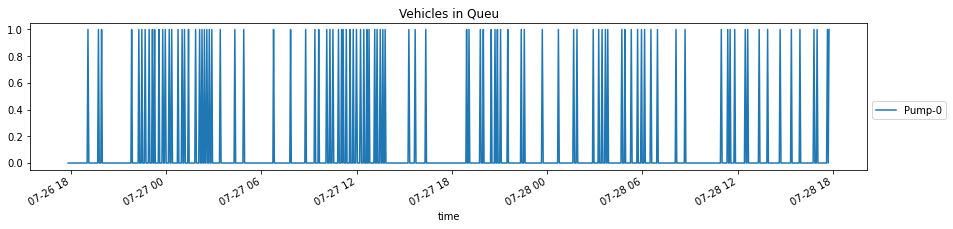

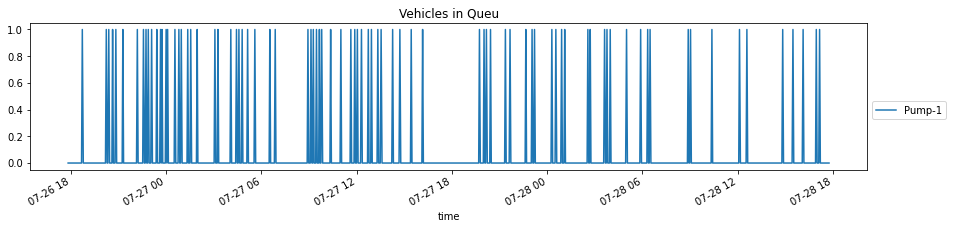

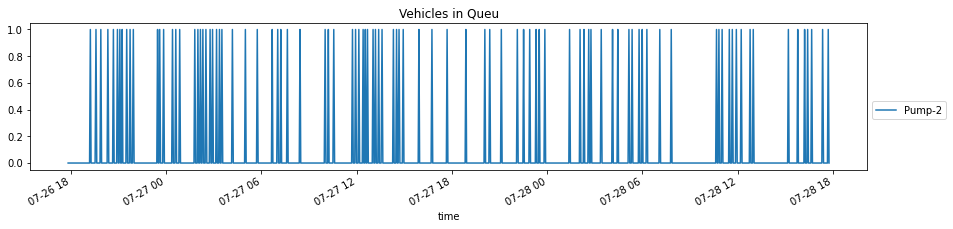

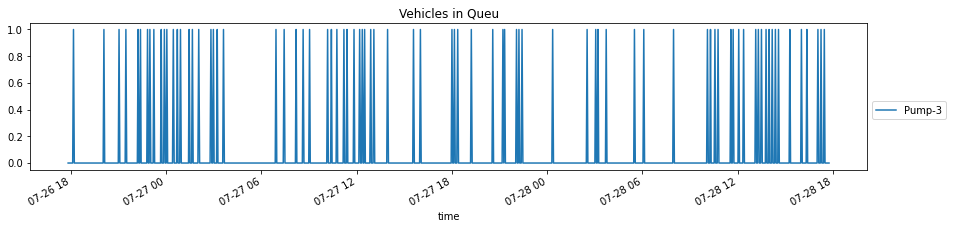

In [584]:
df = pd.DataFrame((env.metrics['queus']['values'])).pivot_table(
    index=['time'],
    columns='pump',
    values='entry_queu'
)

for col in df:
    plt.figure()
    df[col].fillna(0).plot(figsize=(15,3), title='Vehicles in Queu').legend(bbox_to_anchor=(1, 0.5))

total served:  954


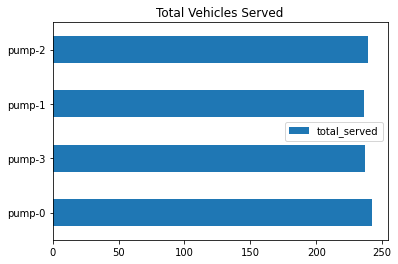

In [585]:
served = {}
for p in pumps:
    served[f"pump-{p.id}"]=p.total_served

pd.DataFrame.from_dict(served, orient='index', columns=['total_served']).plot(kind='barh', title='Total Vehicles Served')

print("total served: ", sum([v for v in served.values()]))

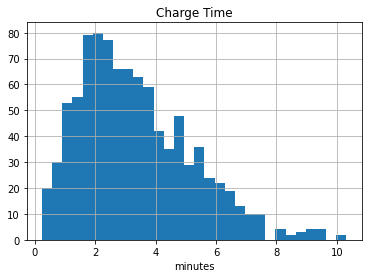

In [586]:
process_time_df = pd.DataFrame((env.metrics['process_time']['values']))

process_time_df['process_time']=process_time_df['process_time']/60

plt.figure()
process_time_df[process_time_df['process_name']=='charge']['process_time'].hist(bins=30)
plt.title("Charge Time")
plt.xlabel("minutes")
plt.show()

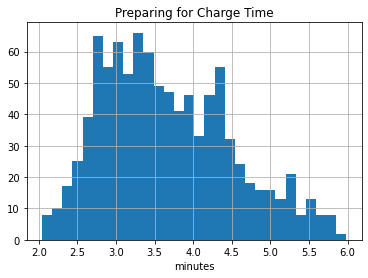

In [587]:
process_time_df[process_time_df['process_name']=='prepare_charge']['process_time'].hist(bins=30)
plt.title("Preparing for Charge Time")
plt.xlabel("minutes")
plt.show()

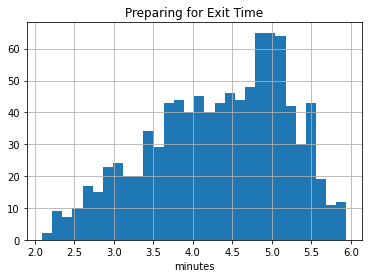

In [588]:
process_time_df[process_time_df['process_name']=='prepare_exit_charge']['process_time'].hist(bins=30)
plt.title("Preparing for Exit Time")
plt.xlabel("minutes")
plt.show()

In [589]:
queu_times = pd.DataFrame(env.metrics['queu_time']['values'])

queu_times['time'] = pd.to_datetime(queu_times['time'])

queu_times['wait_time'] = queu_times.sort_values(
    ['vehicle','pump','time']
    ).groupby(
        ['vehicle','pump']
    )['time'].diff(1).dt.total_seconds()
queu_times['wait_time'] = queu_times['wait_time']/60   

C:\Users\vitos\AppData\Local\Temp\ipykernel_27164\2675621428.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  queu_times.sort_values(['vehicle','pump','time'])[


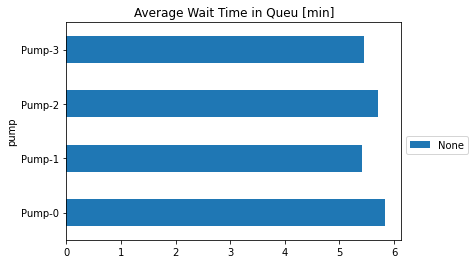

In [590]:
queu_times.sort_values(['vehicle','pump','time'])[
    (queu_times['action']=='exited')
].pivot_table(
    index=['time'],
    columns='pump',
    values='wait_time'
).mean().plot(kind='barh', title='Average Wait Time in Queu [min]').legend(bbox_to_anchor=(1, 0.5))
plt.show()

C:\Users\vitos\AppData\Local\Temp\ipykernel_27164\3361006301.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  queu_times.sort_values(['vehicle','pump','time'])[


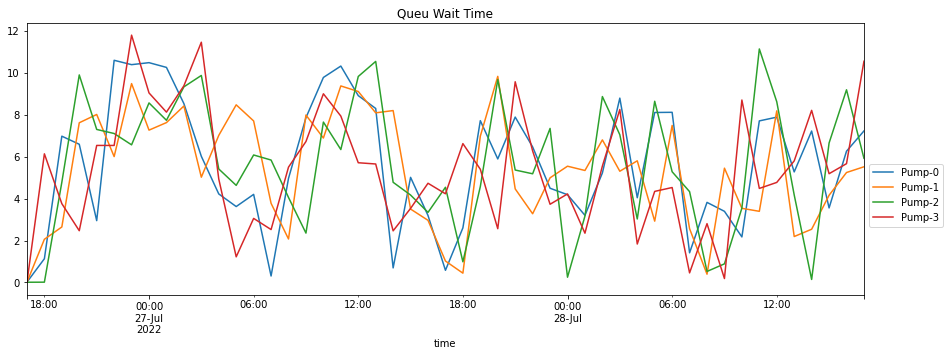

In [591]:
queu_times.sort_values(['vehicle','pump','time'])[
    (queu_times['action']=='exited')
].pivot_table(
    index=['time'],
    columns='pump',
    values='wait_time'
).resample('60Min').mean().fillna(0).plot(figsize=(15,5),title='Queu Wait Time').legend(bbox_to_anchor=(1, 0.5))

In [592]:
# queu_times.sort_values(['vehicle','pump','time'])[
#     (queu_times['action']=='exited')
# ].pivot_table(
#     index=['time'],
#     columns=['pump'],
#     values='wait_time'
# ).resample("1Min").mean().fillna(0).plot().legend(bbox_to_anchor=(1, 0.5))

In [593]:
siezed_time = pd.DataFrame(env.metrics['siezed_time']['values'])

siezed_time['time'] = pd.to_datetime(siezed_time['time'])

siezed_times = []
for e in siezed_time['employee'].unique():
    e_siezed_time = siezed_time[siezed_time['employee']==e].copy()
    e_siezed_time['siezed_time'] = e_siezed_time.sort_values(
        ['employee','time']
    )['time'].diff(1).dt.total_seconds()
    e_siezed_time['siezed_time'] = e_siezed_time['siezed_time']/60
    siezed_times.append(e_siezed_time)

siezed_times = pd.concat(siezed_times)

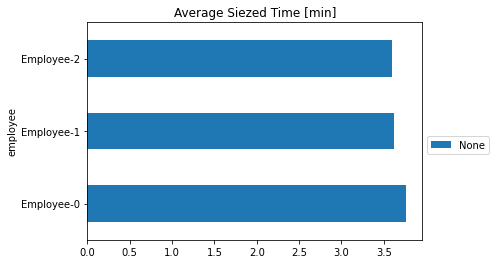

In [594]:
siezed_times[
    siezed_times['action']=='release'
    ].pivot_table(
    index=['time'],
    columns='employee',
    values='siezed_time'
).mean().plot(kind='barh', title='Average Siezed Time [min]').legend(bbox_to_anchor=(1, 0.5))

plt.show()


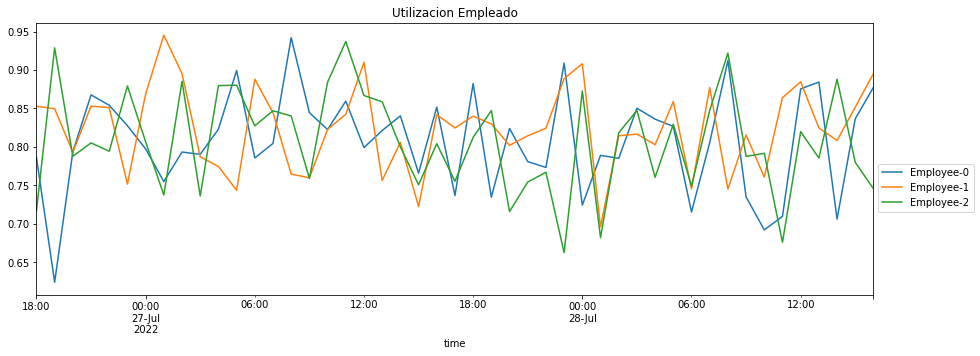

In [595]:
siezed_times[
    siezed_times['action']=='release'
    ].pivot_table(
    index=['time'],
    columns='employee',
    values='siezed_time'
).resample("60Min").sum().pipe(lambda df: df/60).iloc[1:-1].plot(figsize=(15,5),title='Utilizacion Empleado').legend(bbox_to_anchor=(1, 0.5))